---
# Quaternions and States

In [1]:
using GLMakie, LinearAlgebra, GeometryBasics, Quaternions
import Quaternions: Quaternion as Quaternion

In [2]:
### Window Management
# Define the display_windows function
function display_windows(scenes...; names::Vector{String}=String[])
    # Create a new window for each scene
    if length(scenes) == length(names)
        for (scene, name) in zip(scenes, names)

            GLMakie.activate!(title=name)
            win = GLMakie.Screen()

            display(win, scene)
        end
    else
        # Else just do window1, window2...
        for (i, scene) in enumerate(scenes)

            GLMakie.activate!(title="Window $i")
            win = GLMakie.Screen()

            display(win, scene)
        end
    end
end### Window Management

display_windows (generic function with 1 method)

In [3]:
function quat_from_axisangle(axis::AbstractVector, theta::Real)
    if length(axis) != 3
        error("Must be a 3-vector")
    end
    s, c = sincos(theta / 2)
    axis = normalize(axis)
    return Quaternion(c, s * axis[1], s * axis[2], s * axis[3])
end
axisangle2quat = quat_from_axisangle

function axisangle_from_quat(q::Quaternion)
    # Check if approximately unit quaternion
    norm_q = norm(q)
    if abs(norm_q - 1) > 1e-6
        error("Quaternion must be unit (norm ≈ 1), got norm = $norm_q")
    end
    if norm_q < 1e-10
        error("Invalid quaternion (zero norm)")
    end

    # Normalize to ensure unit quaternion
    q = normalize(q)

    # Extract scalar and vector parts
    w = real(q)
    v = Vec{3,Float64}(q.v1, q.v2, q.v3)

    # Compute angle: θ = 2 * arccos(w)
    theta = 2 * acos(clamp(w, -1.0f0, 1.0f0))

    # Compute axis
    sin_half_theta = sqrt(1 - w^2)  # sin(θ/2) = sqrt(x^2 + y^2 + z^2)
    if sin_half_theta < 1e-6
        # θ ≈ 0 or 2π, axis is undefined, use default (e.g., z-axis)
        axis = Vec{3,Float64}(0, 0, 1)
    else
        axis = v / sin_half_theta
        # Ensure axis is unit vector
        axis_norm = norm(axis)
        if axis_norm < 1e-10
            axis = Vec{3,Float64}(0, 0, 1)
        else
            axis = axis / axis_norm
        end
    end

    return axis, Float64(theta)
end
quat2axisangle = axisangle_from_quat

function rotate_vector(q::Quaternion, u::AbstractVector)
    if length(u) != 3
        error("Must be a 3-vector")
    end
    q_u = Quaternion(0, u[1], u[2], u[3])
    q_v = q * q_u * conj(q)
    return [imag_part(q_v)...]
end

function quat_from_rotmatrix(dcm::AbstractMatrix{T}) where {T<:Real}
    tr = dcm[1, 1] + dcm[2, 2] + dcm[3, 3]
    if tr > 0
        S = sqrt(tr + 1.0) * 2
        w = 0.25 * S
        x = (dcm[3, 2] - dcm[2, 3]) / S
        y = (dcm[1, 3] - dcm[3, 1]) / S
        z = (dcm[2, 1] - dcm[1, 2]) / S
    elseif (dcm[1, 1] > dcm[2, 2]) && (dcm[1, 1] > dcm[3, 3])
        S = sqrt(1.0 + dcm[1, 1] - dcm[2, 2] - dcm[3, 3]) * 2
        w = (dcm[3, 2] - dcm[2, 3]) / S
        x = 0.25 * S
        y = (dcm[1, 2] + dcm[2, 1]) / S
        z = (dcm[1, 3] + dcm[3, 1]) / S
    elseif dcm[2, 2] > dcm[3, 3]
        S = sqrt(1.0 + dcm[2, 2] - dcm[1, 1] - dcm[3, 3]) * 2
        w = (dcm[1, 3] - dcm[3, 1]) / S
        x = (dcm[1, 2] + dcm[2, 1]) / S
        y = 0.25 * S
        z = (dcm[2, 3] + dcm[3, 2]) / S
    else
        S = sqrt(1.0 + dcm[3, 3] - dcm[1, 1] - dcm[2, 2]) * 2
        w = (dcm[2, 1] - dcm[1, 2]) / S
        x = (dcm[1, 3] + dcm[3, 1]) / S
        y = (dcm[2, 3] + dcm[3, 2]) / S
        z = 0.25 * S
    end
    return Quaternion(w, x, y, z)
end
rotmatrix2quat = quat_from_rotmatrix
function rotmatrix_from_quat(q::Quaternion)
    sx, sy, sz = 2q.s * q.v1, 2q.s * q.v2, 2q.s * q.v3
    xx, xy, xz = 2q.v1^2, 2q.v1 * q.v2, 2q.v1 * q.v3
    yy, yz, zz = 2q.v2^2, 2q.v2 * q.v3, 2q.v3^2
    r = [1-(yy+zz) xy-sz xz+sy;
        xy+sz 1-(xx+zz) yz-sx;
        xz-sy yz+sx 1-(xx+yy)]
    return r
end
quat2rotmatrix = rotmatrix_from_quat

function axisangle2rotmatrix(axis::AbstractVector, theta::Real)
    return rotmatrix_from_quat(quat_from_axisangle(axis, theta))
end
rotmatrix_from_axisangle = axisangle2rotmatrix


println("Avaialble functions:")
function_list = [:axisangle2quat, :quat2axisangle, :rotate_vector, :rotmatrix2quat, :quat2rotmatrix, :axisangle2rotmatrix]
for f in function_list
    println(f)
end


Avaialble functions:
axisangle2quat
quat2axisangle
rotate_vector
rotmatrix2quat
quat2rotmatrix
axisangle2rotmatrix


In [4]:
axisangle2rotmatrix([0, 0, 1], π / 2) * [1, 0, 0] ≈ [0, 1, 0]# should be [0, 1, 0]

true

In [5]:


mutable struct State
    # Define Standard State to be [[0,0,1], [0,1,0], [1,0,0]] and rotation from standard state is null therefore standard q = [1,0,0,0]
    ex::Point{3,Float64}
    ey::Point{3,Float64}
    ez::Point{3,Float64}
    q::Quaternion
end

# State Constructor, given a Quaternion
function State(q::Quaternion)
    q = normalize(q)

    r = quat2rotmatrix(q)
    ex = Point{3,Float64}(r[:, 1])
    ey = Point{3,Float64}(r[:, 2])
    ez = Point{3,Float64}(r[:, 3])
    return State(ex, ey, ez, q)
end

# State Constructor, given state vectors
function State(ex::AbstractVector{<:Real}, ey::AbstractVector{<:Real}, ez::AbstractVector{<:Real})
    ex_f = Point{3,Float64}(ex)
    ey_f = Point{3,Float64}(ey)
    ez_f = Point{3,Float64}(ez)

    # normalize vectors
    ex_f = normalize(ex_f)
    ey_f = normalize(ey_f)
    ez_f = normalize(ez_f)

    # check orthonormality by calculating pairwise dot products
    if abs(dot(ex_f, ey_f)) > 1e-6 || abs(dot(ex_f, ez_f)) > 1e-6 || abs(dot(ey_f, ez_f)) > 1e-6
        error("Vectors are not orthonormal")
    end

    q = rotmatrix2quat([Vector(ex_f), Vector(ey_f), Vector(ez_f)])

    return State(ex_f, ey_f, ez_f, q)
end

# State Constructor, given a rotation matrix
function State(r::AbstractMatrix{<:Real})
    return State(r[:, 1], r[:, 2], r[:, 3])
end

# Default State
State() = State(Quaternion(1.0, 0.0, 0.0, 0.0)) # Default State

State

In [6]:
# Function to create an arrow mesh using native Cylinder and Cone
function create_arrow_mesh_native(shaft_length::AbstractFloat, shaft_radius::AbstractFloat, head_length::AbstractFloat, head_base_radius::AbstractFloat, quality::Int=32)
    # Convert to Float32 for consistency
    sl = Float32(shaft_length)
    sr = Float32(shaft_radius)
    hl = Float32(head_length)
    hbr = Float32(head_base_radius)

    # Create the shaft (Cylinder from z=0 to z=shaft_length)
    shaft = Cylinder(Point3f(0, 0, 0), Point3f(0, 0, sl), sr)

    # Create the arrowhead (Cone from z=shaft_length to z=shaft_length+head_length)
    Cone(; quality) = merge([
        Makie._circle(Point3f(0, 0, 0), hbr, Vec3f(0, 0, -1), quality),
        Makie._mantle(Point3f(0, 0, 0), Point3f(0, 0, hl), hbr, 0f0, quality)
    ])
    cone = Cone(; quality=quality)

    # Convert to meshes
    shaft_mesh = GeometryBasics.mesh(shaft)
    cone_mesh = GeometryBasics.mesh(cone)

    # Translate the cone mesh to sit on top of the shaft
    cone_positions = cone_mesh.vertex_attributes[1]
    translated_positions = [Point3f(p[1], p[2], p[3] + sl) for p in cone_positions]
    cone_faces = cone_mesh.faces
    translated_cone_mesh = GeometryBasics.mesh(translated_positions, cone_faces)

    # Merge the two meshes
    shaft_positions = shaft_mesh.vertex_attributes[1]
    shaft_faces = shaft_mesh.faces
    cone_base_idx = length(shaft_positions) + 1
    merged_positions = vcat(shaft_positions, translated_positions)
    merged_faces = vcat(shaft_faces, [GLTriangleFace(f[1] + cone_base_idx - 1, f[2] + cone_base_idx - 1, f[3] + cone_base_idx - 1) for f in cone_faces])
    merged_mesh = GeometryBasics.mesh(merged_positions, merged_faces)

    return merged_mesh
end

mutable struct Arrow
    tail::Point{3,Float64}
    head::Point{3,Float64}
    shaft_length::Float64
    head_length::Float64
    shaft_radius::Float64
    head_radius::Float64
    quality::Int
    mesh::GeometryBasics.Mesh
end

# Constructor for Arrow given two points
function Arrow(tail::Point{3,<:Real}, head::Point{3,<:Real}; arrow_to_body_ratio::Union{Real,Nothing}=nothing, shaft_radius::Union{Real,Nothing}=nothing, head_radius::Union{Real,Nothing}=nothing, quality::Int=32)
    tail_f = Point{3,Float64}(tail)
    head_f = Point{3,Float64}(head)

    arrow_length = norm(head_f - tail_f)

    if isnothing(arrow_to_body_ratio)
        arrow_to_body_ratio = (1 - exp(-sqrt(arrow_length)) + 2 / 3 + exp(-1 / sqrt(arrow_length)) / 3) / 2
    end
    shaft_length = Float64(arrow_to_body_ratio) * arrow_length
    head_length = arrow_length - shaft_length

    if isnothing(shaft_radius)
        shaft_radius = head_length / 5
    end

    if isnothing(head_radius)
        head_radius = Float64(shaft_radius) * (3 - arrow_to_body_ratio)
    end

    base_mesh = create_arrow_mesh_native(shaft_length, Float64(shaft_radius), head_length, Float64(head_radius), quality)

    direction = head_f - tail_f # Direction vector from tail to head
    length_dir = norm(direction)
    if length_dir < 1e-10
        println("Direction vector has zero length, picking default direction for a small arrow.")
        random_dir = rand(Vec{3,Float64}) .* 1e-5
        return Arrow(tail_f, Point{3,Float64}(random_dir); arrow_to_body_ratio=arrow_to_body_ratio, shaft_radius=shaft_radius, head_radius=head_radius, quality=quality)
    end

    normalized_dir = normalize(direction)

    z_axis = Vec{3,Float64}(0, 0, 1)
    axis = cross(z_axis, Vec{3,Float64}(normalized_dir))
    angle = acos(clamp(dot(z_axis, Vec{3,Float64}(normalized_dir)), -1.0, 1.0))

    if norm(axis) < 1e-10
        if normalized_dir[3] < 0
            rotation = Matrix{Float64}([
                1 0 0
                0 -1 0
                0 0 -1
            ])
        else
            rotation = Matrix{Float64}(I, 3, 3)
        end
    else
        rotation = axisangle2rotmatrix(axis, angle)
    end

    positions = base_mesh.vertex_attributes[1]
    rotated_positions = [Point{3,Float64}(rotation * Vec{3,Float64}(p[1], p[2], p[3])) for p in positions]
    faces = base_mesh.faces
    translated_positions = [tail_f + p for p in rotated_positions]
    translated_mesh = GeometryBasics.mesh(translated_positions, faces)

    return Arrow(tail_f, head_f, shaft_length, head_length, Float64(shaft_radius), Float64(head_radius), quality, translated_mesh)
end

# Constructor for Arrow given a point and a direction vector
function Arrow(tail::Point{3,<:Real}, direction::Vec{3,<:Real}; arrow_to_body_ratio::Union{Real,Nothing}=nothing, shaft_radius::Union{Real,Nothing}=nothing, head_radius::Union{Real,Nothing}=nothing, quality::Int=32)
    direction_vec = Vec{3,Float64}(direction)
    tail_f = Point{3,Float64}(tail)
    head = tail_f + normalize(direction_vec) * norm(direction_vec)
    return Arrow(tail_f, head; arrow_to_body_ratio=arrow_to_body_ratio, shaft_radius=shaft_radius, head_radius=head_radius, quality=quality)
end

# Standard Arrow with tail at origin
function Arrow(direction::Union{Point{3,<:Real},Vec{3,<:Real}}=Point{3,Float64}(0, 0, 1); arrow_to_body_ratio::Union{Real,Nothing}=nothing, shaft_radius::Union{Real,Nothing}=nothing, head_radius::Union{Real,Nothing}=nothing, quality::Int=32)
    tail = Point{3,Float64}(0, 0, 0)
    return Arrow(tail, direction; arrow_to_body_ratio=arrow_to_body_ratio, shaft_radius=shaft_radius, head_radius=head_radius, quality=quality)
end


Arrow

In [7]:
function drawState!(scene::Scene, state::State=State(); location::Point{3,<:Real}=Point(0, 0, 0), scale::Real=1, alpha::Real=1.0)
    # Draw the state vectors
    ex = state.ex
    ey = state.ey
    ez = state.ez

    # Create arrows for each vector
    ex_arrow = Arrow(location, location + scale * ex)
    ey_arrow = Arrow(location, location + scale * ey)
    ez_arrow = Arrow(location, location + scale * ez)

    if alpha != 1
        transparency = true
    else
        transparency = false
    end

    # Add arrows to the scene
    a = mesh!(scene, ex_arrow.mesh; color=(1, 0, 0, alpha), transparency=transparency)
    b = mesh!(scene, ey_arrow.mesh; color=(0, 1, 0, alpha), transparency=transparency)
    c = mesh!(scene, ez_arrow.mesh; color=(0, 0, 1, alpha), transparency=transparency)

    return (a, b, c)
end

drawState! (generic function with 2 methods)

---
Testing...

In [ ]:
scene = Scene(camera=cam3d!)
drawState!(scene)
s = State(Quaternion(rand(4)...))
drawState!(scene, s; alpha=0.5, scale=0.5)
display(scene)

GLMakie.Screen(...)

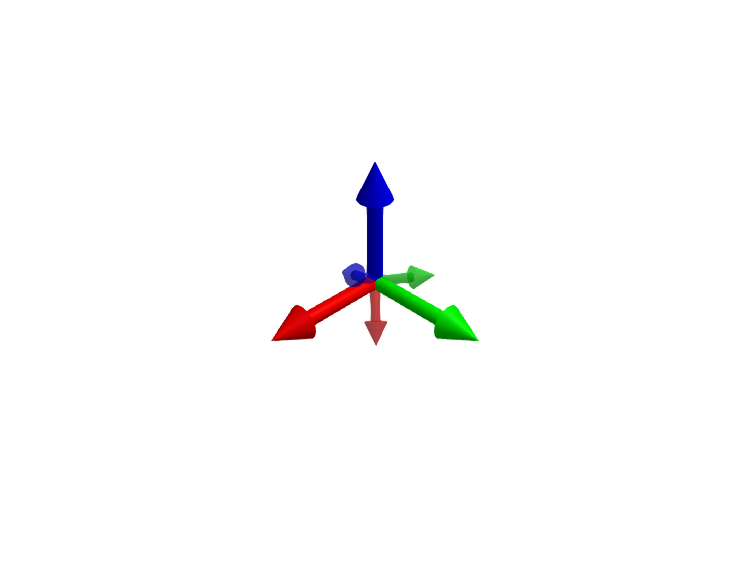

GLMakie.Screen(...)

In [24]:
# To Show in inline output in Jupyter, use GLMakie.Makie.inline!(true)
GLMakie.Makie.inline!(true)
display(scene)

In [26]:
GLMakie.Makie.inline!(false) # To disable inline output

false

In [ ]:
# Look at what happens when you multiply two quaternions
q0 = Quaternion(1, 0, 0, 0)
q1 = axisangle2quat([1, 0, 0], π / 2)
q2 = axisangle2quat([0, 1, 0], π / 2)
q3 = axisangle2quat([0, 0, 1], π / 2)

q12 = q1 * q2
q23 = q2 * q3
q31 = q3 * q1

q123 = q1 * q2 * q3

s = Scene(camera=cam3d!)
drawState!(s, State(q0); scale=1)
display(s)

GLMakie.Screen(...)

In [28]:
drawState!(s, State(q1); scale=0.75, alpha=0.5)

(MakieCore.Mesh{Tuple{GeometryBasics.Mesh{3, Float64, NgonFace{3, OffsetInteger{-1, UInt32}}, (:position, :normal), Tuple{Vector{Point{3, Float64}}, Vector{Vec{3, Float32}}}, Vector{NgonFace{3, OffsetInteger{-1, UInt32}}}}}}, MakieCore.Mesh{Tuple{GeometryBasics.Mesh{3, Float64, NgonFace{3, OffsetInteger{-1, UInt32}}, (:position, :normal), Tuple{Vector{Point{3, Float64}}, Vector{Vec{3, Float32}}}, Vector{NgonFace{3, OffsetInteger{-1, UInt32}}}}}}, MakieCore.Mesh{Tuple{GeometryBasics.Mesh{3, Float64, NgonFace{3, OffsetInteger{-1, UInt32}}, (:position, :normal), Tuple{Vector{Point{3, Float64}}, Vector{Vec{3, Float32}}}, Vector{NgonFace{3, OffsetInteger{-1, UInt32}}}}}})

In [29]:
drawState!(s, State(q2); scale=0.75, alpha=0.5)


(MakieCore.Mesh{Tuple{GeometryBasics.Mesh{3, Float64, NgonFace{3, OffsetInteger{-1, UInt32}}, (:position, :normal), Tuple{Vector{Point{3, Float64}}, Vector{Vec{3, Float32}}}, Vector{NgonFace{3, OffsetInteger{-1, UInt32}}}}}}, MakieCore.Mesh{Tuple{GeometryBasics.Mesh{3, Float64, NgonFace{3, OffsetInteger{-1, UInt32}}, (:position, :normal), Tuple{Vector{Point{3, Float64}}, Vector{Vec{3, Float32}}}, Vector{NgonFace{3, OffsetInteger{-1, UInt32}}}}}}, MakieCore.Mesh{Tuple{GeometryBasics.Mesh{3, Float64, NgonFace{3, OffsetInteger{-1, UInt32}}, (:position, :normal), Tuple{Vector{Point{3, Float64}}, Vector{Vec{3, Float32}}}, Vector{NgonFace{3, OffsetInteger{-1, UInt32}}}}}})

In [30]:
drawState!(s, State(q123); scale=0.5, alpha=0.25)


(MakieCore.Mesh{Tuple{GeometryBasics.Mesh{3, Float64, NgonFace{3, OffsetInteger{-1, UInt32}}, (:position, :normal), Tuple{Vector{Point{3, Float64}}, Vector{Vec{3, Float32}}}, Vector{NgonFace{3, OffsetInteger{-1, UInt32}}}}}}, MakieCore.Mesh{Tuple{GeometryBasics.Mesh{3, Float64, NgonFace{3, OffsetInteger{-1, UInt32}}, (:position, :normal), Tuple{Vector{Point{3, Float64}}, Vector{Vec{3, Float32}}}, Vector{NgonFace{3, OffsetInteger{-1, UInt32}}}}}}, MakieCore.Mesh{Tuple{GeometryBasics.Mesh{3, Float64, NgonFace{3, OffsetInteger{-1, UInt32}}, (:position, :normal), Tuple{Vector{Point{3, Float64}}, Vector{Vec{3, Float32}}}, Vector{NgonFace{3, OffsetInteger{-1, UInt32}}}}}})

In [ ]:
q1 = normalize(Quaternion(rand(4)...))
q2 = normalize(Quaternion(rand(4)...))
qStar = q2 * inv(q1)

n = 10000
k = rand(1:n) / n
axis, theta = quat2axisangle(qStar)
qStar_n = axisangle2quat(axis, theta / n)

println(qStar * q1 ≈ q2)



true


In [32]:
Q1 = copy(q1)
for i in 1:k*n
    Q1 = qStar_n * Q1
end
Q1

QuaternionF64(0.7775961289878538, 0.2496958494637606, 0.5055639094661412, 0.27821102851837687)

In [ ]:
Q2 = axisangle2quat(axis, theta * k) * q1

QuaternionF64(0.7775961289877468, 0.24969584946372864, 0.5055639094660782, 0.278211028518342)

In [34]:
slerp(q1, q2, k) ≈ Q1 ≈ Q2

true

---

In [ ]:
# Randomly Rotating Unit Vector 

using DataStructures: CircularBuffer
# Other imports have been done at the start

scene = Scene(camera=cam3d!, size=(1920, 1080))
drawState!(scene)
meshscatter!(scene, (0, 0, 0), marker=:Sphere, color=:yellow, markersize=1, alpha=0.1, transparency=true)

# Declare observable parameters q, state and arrow, all linked to the quaternion q
q = Observable(Quaternion(1.0, 0.0, 0.0, 0.0))
state = lift(State, q) # Creates an observable state
arrow = lift(s -> Arrow(normalize(s.ex + s.ey + s.ez)), state) # Creates an observable arrow

meshscatter!(scene, (0, 0, 0), marker=lift(a -> a.mesh, arrow), color=:black, markersize=1)



# Create a circular buffer to store the last 20 iterations, storing the arrow head
n = 200 # Buffer size
buffer = CircularBuffer{Point{3,Float64}}(n)
for _ in 1:n
    push!(buffer, copy(arrow[].head))
end
buffer_obs = Observable(buffer)



# Use buffer_obs in plot
lines!(scene, lift(x -> collect(x), buffer_obs), color=[GLMakie.RGBA(0, 0, 0, 1 - i / n) for i in 0:n-1], linewidth=2)


# Animation and keypress handling
is_running = Observable(true)


on(events(scene).keyboardbutton) do event
    if event.action == Keyboard.press && event.key == Keyboard.space
        is_running[] = !is_running[]
        flag = false
    end
    if event.action == Keyboard.press && event.key == Keyboard.a
        global iter = true
    end
end


# Animation loop

display(scene)


# @async record(scene, "slerp_with_state_high_quality_v2.mp4"; framerate = 30) do io
@async begin
    v = drawState!(scene, State(q[]); alpha=0.5, scale=0.5)

    sleep(1) # Wait for the scene to be displayed
    iterations = 100 # Number of iterations per slerp
    rate_function(t) = sin(t * pi / 2) # Rate function for the animation #f(t=0)=0 and f(t=1)=1

    camc = cameracontrols(scene)
    iter = 0

    while is_running[]
        # Generate a random quaternion, slerp it with the current quaternion, and update the observable
        q_new = normalize(Quaternion(rand(4)...))
        q_old = q[]

        # Plot the new target point for the arrow
        target_state = State(q_new)
        target_point = normalize(target_state.ex + target_state.ey + target_state.ez)
        target = meshscatter!(scene, target_point, color=:brown, markersize=0.05, alpha=0.5, transparency=true)

        # Draw the target state coordinate basis
        u = drawState!(scene, target_state; alpha=0.05, scale=0.5)

        # Draw the Axis of rotation
        q_star = q_new * inv(q_old)
        axis, theta = quat2axisangle(q_star)
        about_axis = meshscatter!(scene, (0, 0, 0), marker=Arrow(axis).mesh, color=:gold, markersize=1, alpha=0.5, transparency=true)

        # Align with the axis of rotation when iter is changed by pressing 'a' for align
        if iter % 3 == 0
            update_cam!(scene, camc, Vec3f(axis .* 3), Vec3f(axis), Vec3f(0, 0, 1)) #eyepos, lookat, upvector
        end

        iter += 1
        # Animate the transition from q_old to q_new
        # Use the slerp function to interpolate between the two quaternions

        for i in 1:iterations

            delete!(scene, v[1])
            delete!(scene, v[2])
            delete!(scene, v[3])

            t = i / iterations
            q[] = slerp(q_old, q_new, rate_function(t))
            # Fix: copy head in animation loop
            push!(buffer_obs[], copy(arrow[].head))
            buffer_obs[] = buffer_obs[] # Notify the buffer to update the visualization

            v = drawState!(scene, State(q[]); alpha=0.5, scale=0.5)

            sleep(0.01) # Sleep for a short duration to control the speed of the animation

            # recordframe!(io)
        end




        delete!(scene, target) # Remove the target point after the animation
        delete!(scene, u[1])
        delete!(scene, u[2])
        delete!(scene, u[3])
        delete!(scene, about_axis)
    end
end

# display(scene)



Task (runnable, started) @0x000001f814374010

In [39]:
using GLMakie: closeall
closeall()

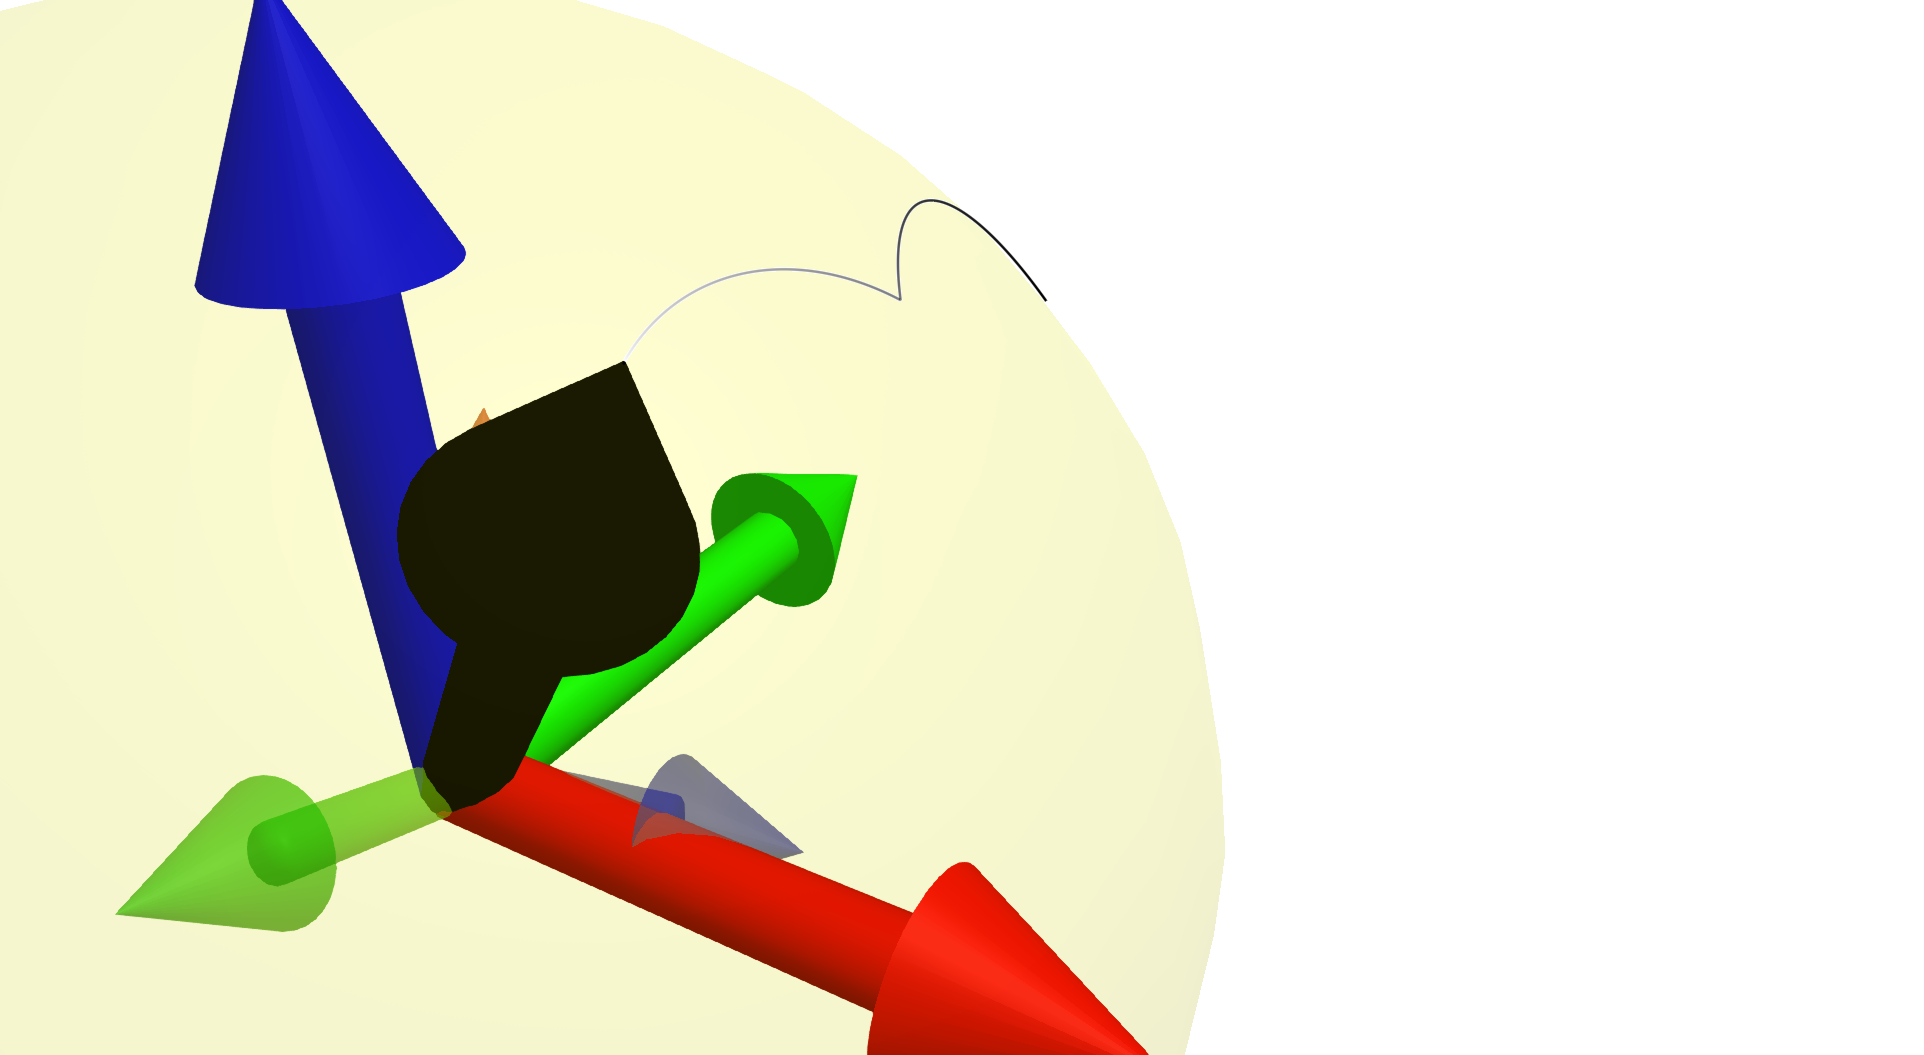

GLMakie.Screen(...)

In [40]:
GLMakie.Makie.inline!(true)
save("curved_motion.png", scene)
display(scene)

In [26]:
GLMakie.Makie.inline!(false)

false

If you are wondering there is something wrong with this motion since the path is not a great Circle, you are right... This should have been a great circle

IF THE GOAL WAS TO MOVE THE ARROW FROM POINT 1 TO POINT 2 ALONE.

BUT!

Out goal is to also rotate the basis around the Arrow, which is not captured by the point alone! We could have gone around the Great circle, and independently rotated about the arrow to reach the desired target state. That is a custom path you can take

BUT! That is not the most efficient path. You can do better...

Remember Euler's Theorem on Rotation? You don't need two different rotations. Instead, you can reach the target state by a single rotation. And that rotation, as it turns out is NOT a geodesic (shortest path on the surface) on the 3D sphere we are plotting. But why is it most effective? Because it is the shortest in the 4D hypersphere of the Unit Quaternion.

It turns out, these slightly curvy looking paths are indeed the most effective to go from state 1 to state 2... you need to curve out a little to incorporate the rotation around the arrow along with the simple translation of the tip of the arrow from point 1 to point 2.

Of course, this might not be what the intend of your mechanism is. In that case, you would have to define custom paths along the Sphere/HyperSphere.

---
## Setup Some conversions between Euler Angles and Quaternions for different Euler Angle Conventions

## Finding the representations of the same physical vector in different frames - Coordinate Transformations

We meant  
$$
v_1 = q_1 v_0 q_1^{-1}
$$

We want $v_2$ such that  
$$
v_1 = q_2 v_2 q_2^{-1}
$$

\[
\begin{aligned}
\Rightarrow v_2 &= q_2^{-1} v_1 q_2 \\
&= q_2^{-1} (q_1 v_0 q_1^{-1}) q_2 \\
&= (q_2^{-1} q_1) v_0 (q_1^{-1} q_2) \\
&= q^* v_0 q^{*-1}
\end{aligned}
\]

where  
$$
q^* = q_2^{-1} q_1
$$

$q^*$ takes you from $q_1$ space $\rightarrow$ std space $\rightarrow q_2$ space.

---

So if you have a vector $v_0$ in $q_1$ space, you transform it to the std state.

So in std basis, $v_0$ would appear as $q_1 v_0 q_1^{-1}$.

To then take this to $q_2$ space by inverse operation of $q_2$:

$v_0$ in $q_1$ space would be $q_2^{-1} q_1 v_0 q_1^{-1} q_2$.

In std basis:

$$
q_2^{-1} q_1 v_0 q_1^{-1} q_2 \quad \text{(in $q_2$ space)}
$$

---

- The operation is $q_2^{-1} q_1$ (i.e., $q_1 \rightarrow \text{std} \rightarrow q_2$ space).
- $q^* = q_2^{-1} q_1$ would be the **change of basis quaternion**.


In [8]:
# Following the above mathematics, hoping I derived the correct equations, I can now write a function to convert between different spaces.

function change_of_basis_quaternion(from::Quaternion, to::Quaternion)
    # Convert q from 'from' basis to 'to' basis
    return inv(to) * from
end

function coordinate_transform(q::Quaternion, from::Quaternion, to::Quaternion=Quaternion(1.0, 0.0, 0.0, 0.0))
    # Convert quaternion q from 'from' basis to 'to' basis
    change_of_basis = change_of_basis_quaternion(from, to)
    return change_of_basis * q * inv(change_of_basis)
end

function coordinate_transform(q::Quaternion, from::State, to::State=State())
    # Convert quaternion q from 'from' basis to 'to' basis
    return coordinate_transform(q, from.q, to.q)
end

function coordinate_transform(v::AbstractVector{<:Real}, from::Quaternion, to::Quaternion=Quaternion(1.0, 0.0, 0.0, 0.0))
    # Convert vector v from 'from' basis to 'to' basis
    q = Quaternion(0, v...) # Ensure from is a State
    transformed_q = coordinate_transform(q, from, to)
    return Point{3,Float64}(imag_part(transformed_q))
end

function coordinate_transform(v::AbstractVector{<:Real}, from::State, to::State=State())
    # Convert vector v from 'from' basis to 'to' basis
    return coordinate_transform(v, from.q, to.q)
end

coordinate_transform (generic function with 8 methods)

In [ ]:
## Testing coordinate transformations for a vector
s = Scene(camera=cam3d!)
drawState!(s)

v0 = Point{3,Float64}([0, 1, 1])
# Draw Arrow A represemtoing v0 in the standard state
arrow_v0 = Arrow(v0)
meshscatter!(s, (0, 0, 0), marker=arrow_v0.mesh, markersize=1, color=:black)

display(s)

state1 = State(Quaternion(0, 1, 1, 0))
drawState!(s, state1; scale=0.75, alpha=0.5)

v1 = coordinate_transform(v0, state1) # You transform the vector v0 defined in state1 basis to the standard state basis
arrow_v1 = Arrow(v1)
meshscatter!(s, (0, 0, 0), marker=arrow_v1.mesh, markersize=0.75, color=:black, alpha=0.5, transparency=true)

MeshScatter{Tuple{Vector{Point{3, Float64}}}}

In [ ]:
## Testing coordinate transformations for a quaternion describing a rotation

axis = [1, 0, 0]
angle = π / 2

body_fixed_rotation = axisangle2quat(axis, angle) #defined within the state state1

# Now we want to represent this rotation in the standard state basis
space_fixed_rotation = coordinate_transform(body_fixed_rotation, state1) # This should correspond to the rotation of standard basis around the x-axis defined in local space by π/2

drawState!(s, State(space_fixed_rotation); scale=2, alpha=0.5)


vertification_state = State(axisangle2quat(coordinate_transform(axis, state1), angle)) # This is the rotation matrix corresponding to the body-fixed rotation
drawState!(s, vertification_state; scale=1, alpha=0.5)

(MakieCore.Mesh{Tuple{GeometryBasics.Mesh{3, Float64, NgonFace{3, OffsetInteger{-1, UInt32}}, (:position, :normal), Tuple{Vector{Point{3, Float64}}, Vector{Vec{3, Float32}}}, Vector{NgonFace{3, OffsetInteger{-1, UInt32}}}}}}, MakieCore.Mesh{Tuple{GeometryBasics.Mesh{3, Float64, NgonFace{3, OffsetInteger{-1, UInt32}}, (:position, :normal), Tuple{Vector{Point{3, Float64}}, Vector{Vec{3, Float32}}}, Vector{NgonFace{3, OffsetInteger{-1, UInt32}}}}}}, MakieCore.Mesh{Tuple{GeometryBasics.Mesh{3, Float64, NgonFace{3, OffsetInteger{-1, UInt32}}, (:position, :normal), Tuple{Vector{Point{3, Float64}}, Vector{Vec{3, Float32}}}, Vector{NgonFace{3, OffsetInteger{-1, UInt32}}}}}})

#### Interpolate Transformation that Supports animation of Arrows that are created through lifting Observable Vectors

In [111]:
# Defining a interpolate transform function for a list of observable vectors defined in coordinates of State A to coordinates of State B, outputting the standard state representation of the same physical vector in the interpolated states.


function interpolate_states(from::Observable{State}, to::State; n::Int=100, time::Real=1.0, rate_function=t -> t)
    # Interpolate between two states from_copy to to with n steps and time duration time
    from_copy = from[] # Copy the initial state
    for i in 1:n
        t = i / n
        from[] = State(slerp(from_copy.q, to.q, rate_function(t)))
        sleep(time / n) # Sleep for a short duration to control the speed of the animation
        yield()
    end
end


function interpolate_vector(
    v1::Observable{AbstractVector{<:Real}},
    v2::AbstractVector{<:Real},
    axis::Union{AbstractVector{<:Real},Nothing}=nothing;
    n::Int=100, time::Real=1.0, rate_function=t -> t
)
    # Animate rotation of v1 to v2 about axis (or cross(v1, v2) if axis is nothing)
    @async begin
        # In principle, rotate_vector(axisangle2quat(axis, angle), v1) should equal v2
        # We must find this angle for the 2 vectors v1 and v2 for the given axis 
        # If the angle exists, we interpolate between the angle and transform v1 into the vectors given by the intermediate angles.
        # If the angle does not exist, throw an error.
        v_start = copy(v1[])
        v_end = normalize(v2)
        v0 = normalize(v_start)
        if isnothing(axis)
            axis = cross(v0, v_end)
            if norm(axis) < 1e-8
                # Vectors are parallel or anti-parallel
                # Pick any perpendicular axis if anti-parallel
                if dot(v0, v_end) < 0
                    axis = abs(v0[1]) < 0.9 ? cross(v0, [1, 0, 0]) : cross(v0, [0, 1, 0])
                else
                    # Already aligned, nothing to do
                    return
                end
            end
        end
        axis = normalize(axis)
        angle = acos(clamp(dot(v0, v_end), -1.0, 1.0))
        if isnan(angle)
            error("The angle between the vectors is not defined.")
        end
        for i in 1:n
            t = i / n
            interpolated_angle = angle * rate_function(t)
            v_interpolated = rotate_vector(axisangle2quat(axis, interpolated_angle), v_start)
            v1[] = v_interpolated
            sleep(time / n)
        end
    end
end

interpolate_vector (generic function with 2 methods)

In [223]:
GLMakie.closeall() # Close all windows

In [227]:
# Testing the interpolate_transform function 

standard_state = State(Quaternion(1.0, 0.0, 0.0, 0.0))
state_a = State(axisangle2quat([1.0, 0.0, 0.0], π / 2)) # 90 degrees around x-axis
state_b = State(axisangle2quat([0.0, 1.0, 0.0], π / 2)) # 90 degrees around y-axis

vector_state = Observable(standard_state)

# Create a list of observable vectors
obsvectors = [Observable(Point{3,Float64}([1, 0, 0])), Observable(Point{3,Float64}([0, 1, 0])), Observable(Point{3,Float64}([0, 0, 1])), Observable(Point{3,Float64}(normalize([1, 1, 1])))]
colors = [:red, :green, :blue, :black] # Colors for the vectors

# Create a vector of Observables that are the obsvectors transformed from vector_state to standard_state through lifting 2 variables 

obsvectors_in_vector_state = [lift((obsvector, vector_state) -> coordinate_transform(obsvector, vector_state), obsvector, vector_state) for obsvector in obsvectors]
observables_in_vector_state = [lift(vector_state -> coordinate_transform(obsvector[], vector_state), vector_state) for obsvector in obsvectors]
# Draw the initial state
s = Scene(camera=cam3d!, size=(1920, 1080))
drawState!(s, standard_state; scale=2, alpha=1)
# Draw the initial vectors in the standard state using the lift function 
for i in eachindex(obsvectors_in_vector_state)
    meshscatter!(s, (0, 0, 0), marker=lift(v -> Arrow(v).mesh, obsvectors_in_vector_state[i]), color=colors[i], markersize=1, alpha=0.5, transparency=true)
end

display(s)

GLMakie.Screen(...)

In [229]:
recording = Observable(true)

on(events(s).keyboardbutton) do event
    if event.action == Keyboard.press && event.key == Keyboard.q
        recording[] = false
    end
end

# Use Makie's record function for video
@async record(s, "EulerAnglesWithWing.mp4"; framerate=30) do io
    sleep(1)  # Wait for the scene to be displayed
    while isopen(s) && recording[]
        recordframe!(io)
        sleep(1/30)
    end
end

Task (runnable, started) @0x0000025e9bd57840

In [132]:
function animate_intrinsic_xyz!(vector_state::Observable{State}, alpha::Real, beta::Real, gamma::Real; n::Int=100, time::Real=1.0, rate_function=t -> t, wait::Real=0.1)
    # Step 1: Rotate about current x axis by alpha
    qx = axisangle2quat([1.0, 0.0, 0.0], alpha)
    q1 = vector_state[].q * qx
    state1 = State(q1)
    interpolate_states(vector_state, state1; n=n, time=time, rate_function=rate_function)
    sleep(wait)

    # Step 2: Rotate about new y axis by beta (body y after x rotation)
    qy = axisangle2quat([0.0, 1.0, 0.0], beta)
    q2 = q1 * qy
    state2 = State(q2)
    interpolate_states(vector_state, state2; n=n, time=time, rate_function=rate_function)
    sleep(wait)

    # Step 3: Rotate about new z axis by gamma (body z after x and y rotations)
    qz = axisangle2quat([0.0, 0.0, 1.0], gamma)
    q3 = q2 * qz
    state3 = State(q3)
    interpolate_states(vector_state, state3; n=n, time=time, rate_function=rate_function)
    sleep(wait)
end

animate_intrinsic_xyz! (generic function with 1 method)

In [170]:
# Suppose you already have vector_state = Observable(State())
animate_intrinsic_xyz!(vector_state, π/3, π/3, π/3; n=100, time=1.0, rate_function=t -> sin(t * pi / 2))

In [ ]:
# # Asynchornously interpolate vector_state from standard_state to state_a and then to state_b
# n = 100;
# time = 1.0;
# rate_function = t -> sin(t * pi / 2); # Rate function for the animation #f(t=0)=0 and f(t=1)=1;
# @async begin
#     for i in 1:n
#         t = i / n
#         vector_state[] = State(slerp(standard_state.q, state_a.q, rate_function(t)))
#         sleep(time / n) # Sleep for a short duration to control the speed of the animation
#     end
#     sleep(0.5) # Wait for the first interpolation to finish
#     for i in 1:n
#         t = i / n
#         vector_state[] = State(slerp(state_a.q, state_b.q, rate_function(t)))
#         sleep(time / n) # Sleep for a short duration to control the speed of the animation
#     end
# end

Task (runnable, started) @0x000001f81413aab0

In [230]:
interpolate_states(vector_state, state_a; n=100, time=1.0, rate_function=t -> sin(t * pi / 2))

In [231]:
interpolate_states(vector_state, state_b; n=100, time=1.0, rate_function=t -> sin(t * pi / 2))

In [232]:
interpolate_states(vector_state, standard_state; n=100, time=1.0, rate_function=t -> sin(t * pi / 2))

<video controls width="640">
  <source src="EulerAngles.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>
---

In [210]:
using GLMakie
using FileIO

wing = load(assetpath("D:/Programming/Flapping Wing Flying Research/Models/edited_wing.STL"))
s = Scene(camera=cam3d!, size=(1920, 1080))
drawState!(s; alpha=0.5)
wingmesh = meshscatter!(s, (0,0,0), marker=wing, markersize=0.0075; color=:brown, transparency=true, alpha=0.5)
display(s)

GLMakie.Screen(...)

In [211]:
using GLMakie
using FileIO
using LinearAlgebra

wing = load(assetpath("D:/Programming/Flapping Wing Flying Research/Models/edited_wing.STL"))
s = Scene(camera=cam3d!, size=(1920, 1080))
drawState!(s; alpha=0.5)

# Define a rotation matrix (e.g., 45 degrees around z-axis)
θ = π/4
R = [cos(θ) -sin(θ) 0;
     sin(θ)  cos(θ) 0;
     0        0     1]

# Rotate mesh vertices
positions = wing.vertex_attributes[1]
rotated_positions = [Point3f(R * Vec3f(p)) for p in positions]
faces = wing.faces
rotated_mesh = GeometryBasics.mesh(rotated_positions, faces)

# Display rotated mesh
wingmesh = meshscatter!(s, (0,0,0), marker=rotated_mesh, markersize=0.0075; color=:brown, transparency=true, alpha=0.5)
display(s)

GLMakie.Screen(...)

In [228]:
using GLMakie
using FileIO
using LinearAlgebra

wing = load(assetpath("D:/Programming/Flapping Wing Flying Research/Models/edited_wing.STL"))

# Observable for the state (already defined in your code)
# vector_state = Observable(standard_state)

# Create an observable mesh that rotates with vector_state
obswingmesh = lift(vector_state) do st
    R = quat2rotmatrix(st.q)
    positions = wing.vertex_attributes[1]
    rotated_positions = [Point3f(R * Vec3f(p)) for p in positions]
    faces = wing.faces
    GeometryBasics.mesh(rotated_positions, faces)
end

s = Scene(camera=cam3d!, size=(1920, 1080))
drawState!(s, standard_state; scale=2, alpha=1)

# Plot the observable mesh
meshscatter!(s, (0,0,0), marker=obswingmesh, markersize=0.0075, color=:brown, transparency=true, alpha=0.5)

# (Optional) Plot the observable arrows as before
for i in eachindex(obsvectors_in_vector_state)
    meshscatter!(s, (0, 0, 0), marker=lift(v -> Arrow(v).mesh, obsvectors_in_vector_state[i]), color=colors[i], markersize=0.5, alpha=0.2, transparency=true)
end

display(s)

GLMakie.Screen(...)

In [233]:
state_up = State(axisangle2quat([1,0,0], π/6))
state_down = State(axisangle2quat([1,0,0], -π/6))

cycles = 10
n = 100
time_per_half = 0.25

for i in 1:cycles
    interpolate_states(vector_state, state_up; n=n, time=time_per_half, rate_function=t -> sin(t * π / 2))
    interpolate_states(vector_state, state_down; n=n, time=time_per_half, rate_function=t -> sin(t * π / 2))
end

In [234]:
state_up = State(axisangle2quat([1,1,0], π/6))
state_down = State(axisangle2quat([1,1,0], -π/6))

cycles = 10
n = 100
time_per_half = 0.25

for i in 1:cycles
    interpolate_states(vector_state, state_up; n=n, time=time_per_half, rate_function=t -> sin(t * π / 2))
    interpolate_states(vector_state, state_down; n=n, time=time_per_half, rate_function=t -> sin(t * π / 2))
end

<video controls width="640">
  <source src="EulerAnglesWithWing.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>